In [1]:
%matplotlib inline
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
print(sklearn.__version__)

1.2.2


In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

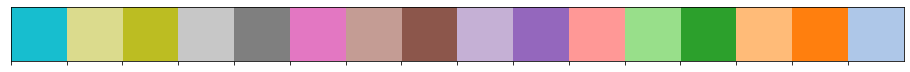

In [3]:
colors = sns.color_palette("tab20_r", 16)
sns.palplot(colors)
sns.set_style("darkgrid")

In [4]:
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error

In [5]:
def  compute_indicator(true_values,predicted_values):
    MSE = mean_squared_error(true_values, predicted_values)
    MAE = mean_absolute_error(true_values, predicted_values)
    RMSE = mean_squared_error(true_values, predicted_values, squared=False)
    MEDAE = median_absolute_error(true_values, predicted_values)
    R2 = r2_score(true_values, predicted_values)
    print("°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°")
    print("---- COMPARISON TRUE / PREDICTED ----")
    print("")
    print(f"MSE ----> {MSE}")
    print(f"RMSE ---> {RMSE}")
    print(f"MAE ----> {MAE}")
    print(f"MEDAE --> {MEDAE}")
    print(f"R2 -----> {R2}")
    print("°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°°")
    return MSE, RMSE, MAE, MEDAE, R2

# Introduction to Ensemble Methods

Ensemble methods are techniques for obtaining better predictive performances by using multiple models.

The following dataset comes from a bank which would like to know when a new client arrives if this client will subscribe to a long term deposit.

The bank will be considered as your client in the following parts.

---

**Feel free to create sklearn Pipelines for simplifying the following experiments** 

## Introducing and exploring the dataset

The dataset is located in `../data/bank-full.csv`. It has 17 columns, the target column or $ŷ$ is the column named `y`.

Columns summary  : 

| column name | simple description |
|-------------|------------------------|
| age | age |
| job | type of job |
| marital | marital status |
| education | education level |
| default | has credit in default? |
| housing | has housing loan? |
| contact | contact communication |
| month | last contact month of year |
| day_of_week | last contact day of the week |
| duration |  last contact duration in seconds |
| campaign |  number of contacts performed during campaign for this client |
| pday | number of days that passed by after the client was last contacted from a previous campaign (999 means client was not previously contacted) |
| previous | number of contacts performed before this campaign and for this client |
| poutcome | outcome of the previous marketing campaign |
| **output :** |  |
| y | has  the client subscribed a term deposit? |

Let's explore the dataset a bit using pandas.

While exploring the dataset it is recommended to create a list of categorical features

# Data exploration

In [6]:
import pandas as pd
import numpy as np
print(sklearn.__version__)

1.2.2


## Importation

Create a dataframe with the dataset `../data/bank-full.csv`

In [7]:
df = pd.read_csv("../data/bank-full.csv", sep=";")#, na_values="unknown")
dff = df.copy()

## Exploration

Describe the dataset informations

In [8]:
df.shape

(45211, 17)

In [9]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [10]:
df["poutcome"].value_counts()

unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [12]:
num_col = ["age", "balance", "day", "duration", "campaign", "pdays", "previous"]
cat_col = df.columns.drop(num_col).tolist()
display(num_col)
display(cat_col)

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'y']

Use histogramms to display the features' distribution

In [13]:
for col in df.columns:
    print("----------------------------------")
    print("----------------------------------")
    print(f"Columns --> {col} <--")
    print(df[col].value_counts())

----------------------------------
----------------------------------
Columns --> age <--
32    2085
31    1996
33    1972
34    1930
35    1894
      ... 
93       2
90       2
95       2
88       2
94       1
Name: age, Length: 77, dtype: int64
----------------------------------
----------------------------------
Columns --> job <--
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64
----------------------------------
----------------------------------
Columns --> marital <--
married     27214
single      12790
divorced     5207
Name: marital, dtype: int64
----------------------------------
----------------------------------
Columns --> education <--
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int

## Graphical representation

### Pairplot

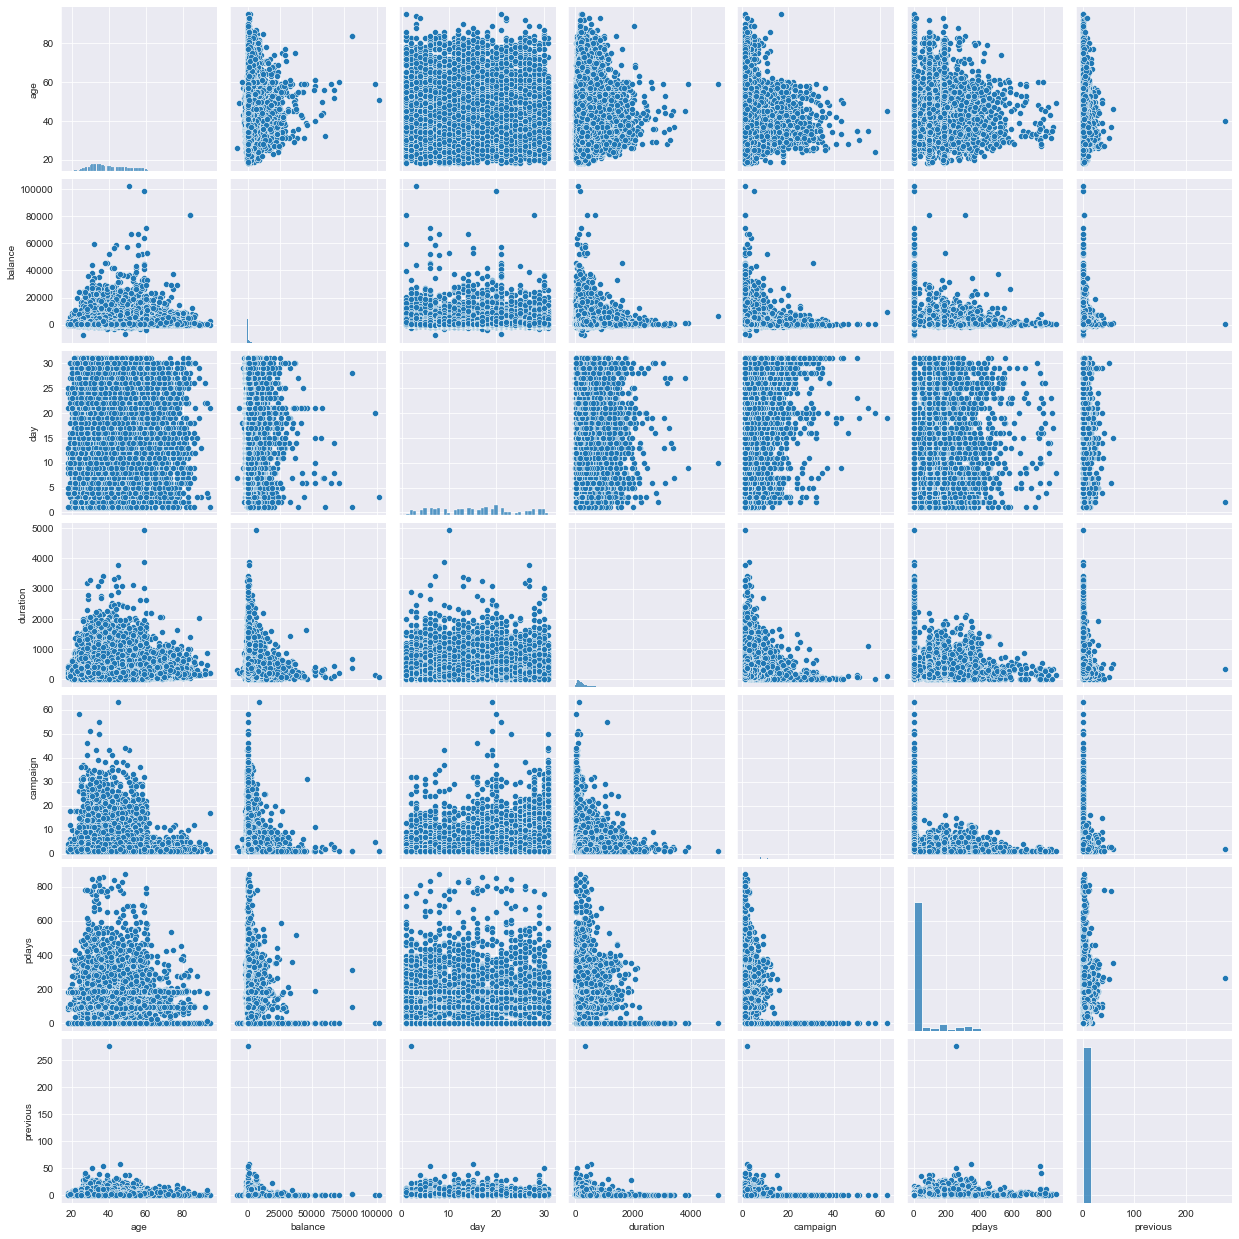

In [14]:
sns.pairplot(df)

### Histograme

--------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------- study of age ------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------

32    2085
31    1996
33    1972
34    1930
35    1894
      ... 
93       2
90       2
95       2
88       2
94       1
Name: age, Length: 77, dtype: int64



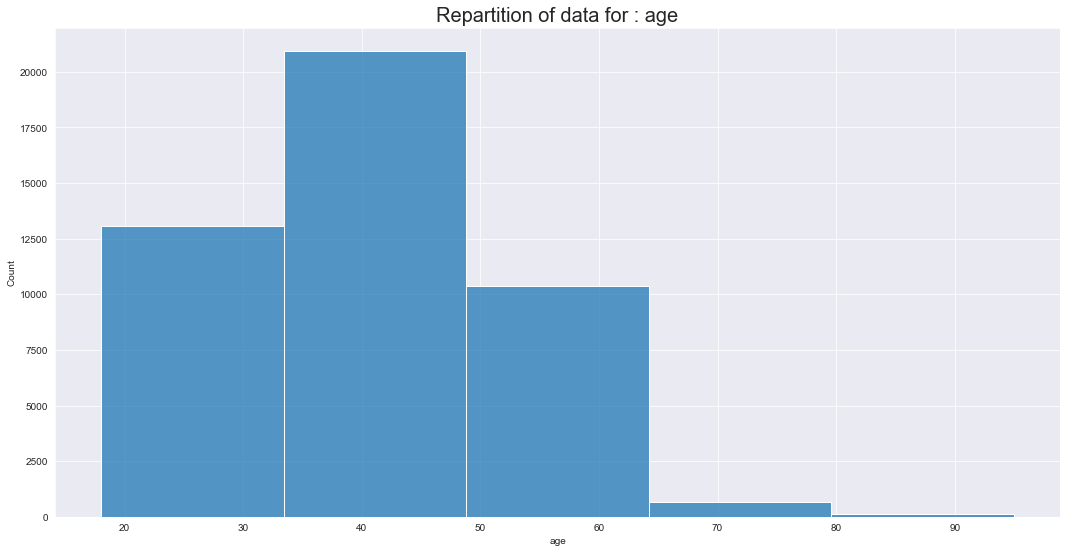

--------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------- study of job ------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64



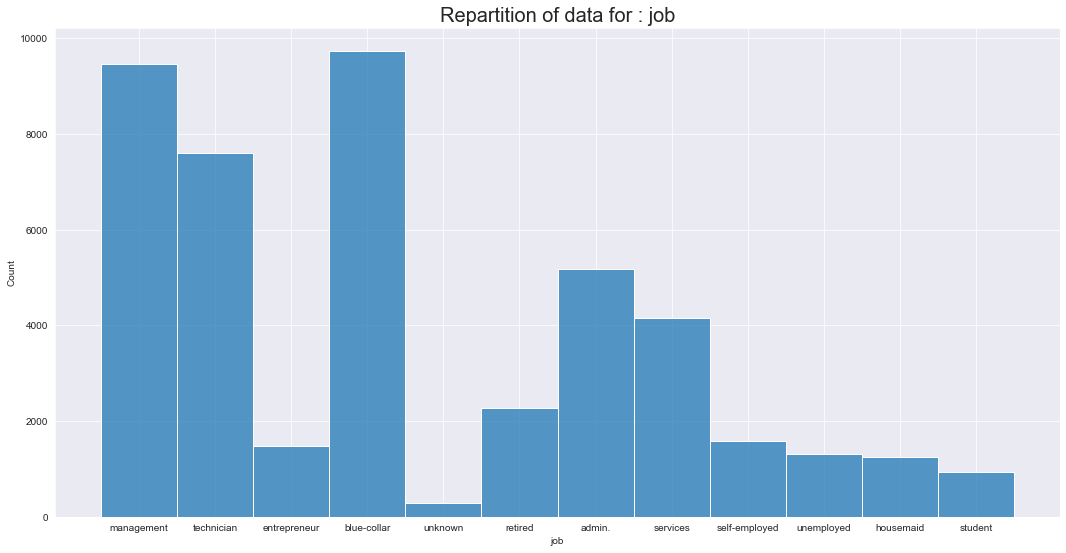

--------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------- study of marital ------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------

married     27214
single      12790
divorced     5207
Name: marital, dtype: int64



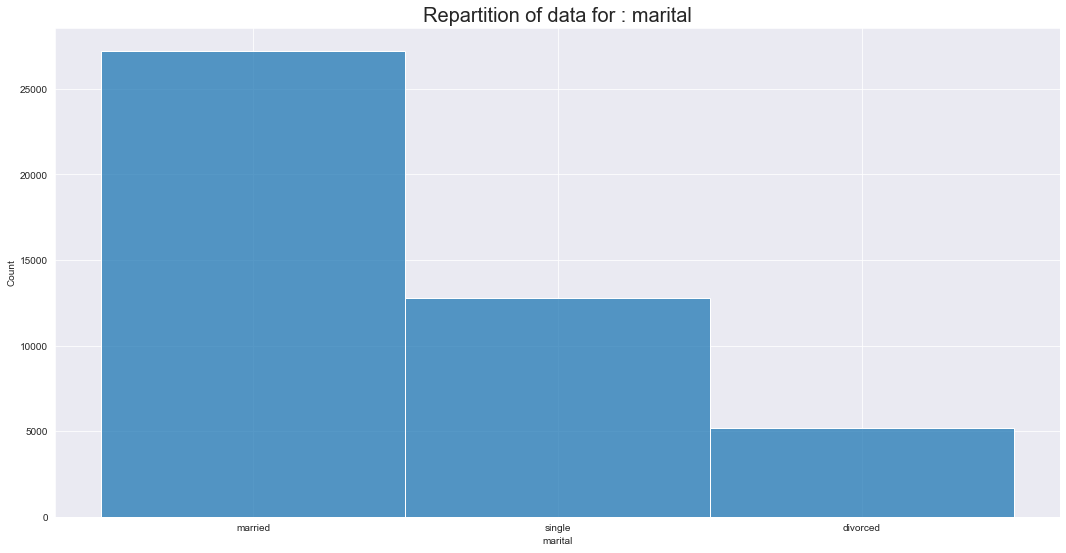

--------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------- study of education ------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------

secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64



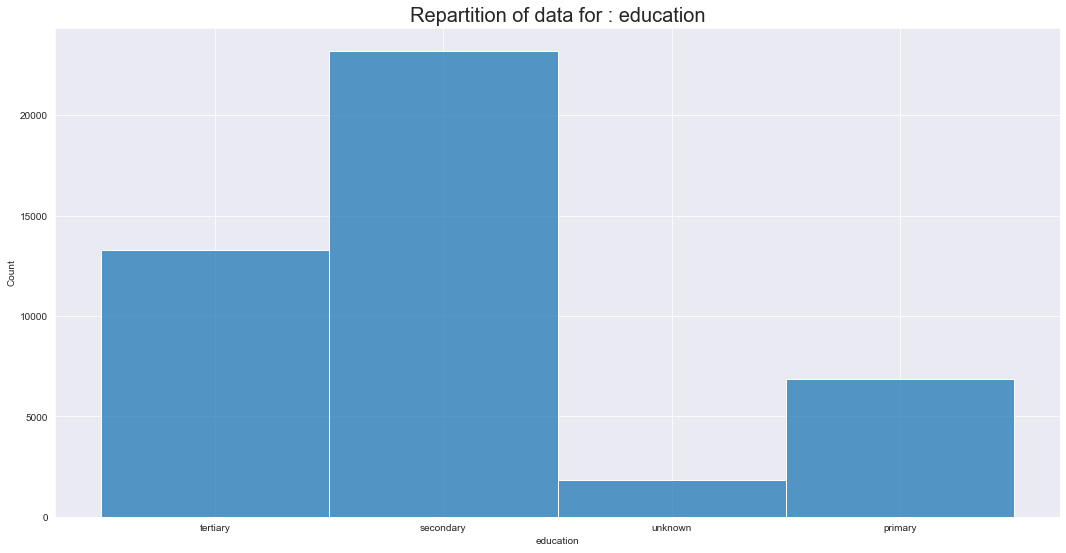

--------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------- study of default ------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------

no     44396
yes      815
Name: default, dtype: int64



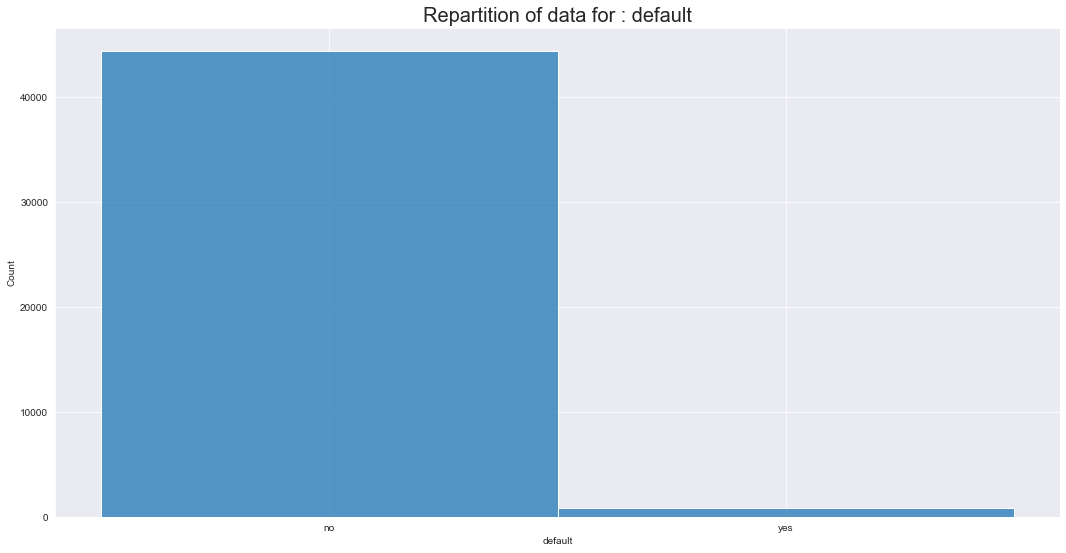

--------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------- study of balance ------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------

 0        3514
 1         195
 2         156
 4         139
 3         134
          ... 
-381         1
 4617        1
 20584       1
 4358        1
 16353       1
Name: balance, Length: 7168, dtype: int64



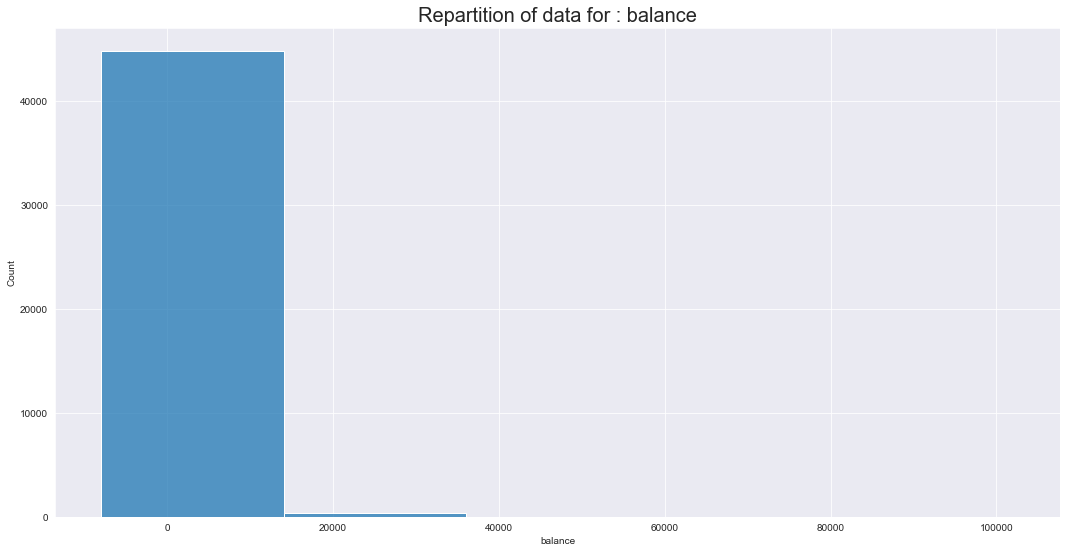

--------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------- study of housing ------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------

yes    25130
no     20081
Name: housing, dtype: int64



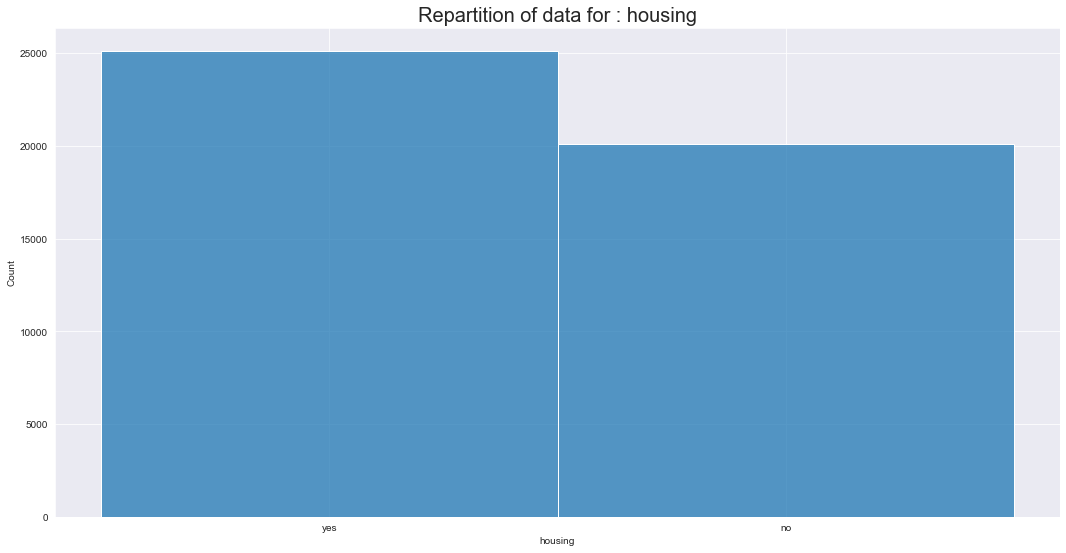

--------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------- study of loan ------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------

no     37967
yes     7244
Name: loan, dtype: int64



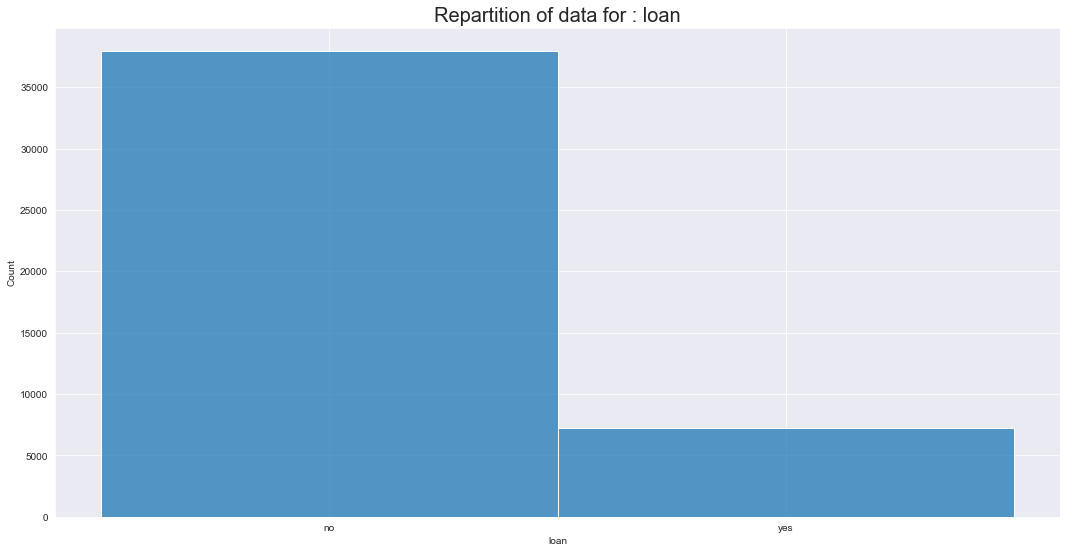

--------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------- study of contact ------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------

cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64



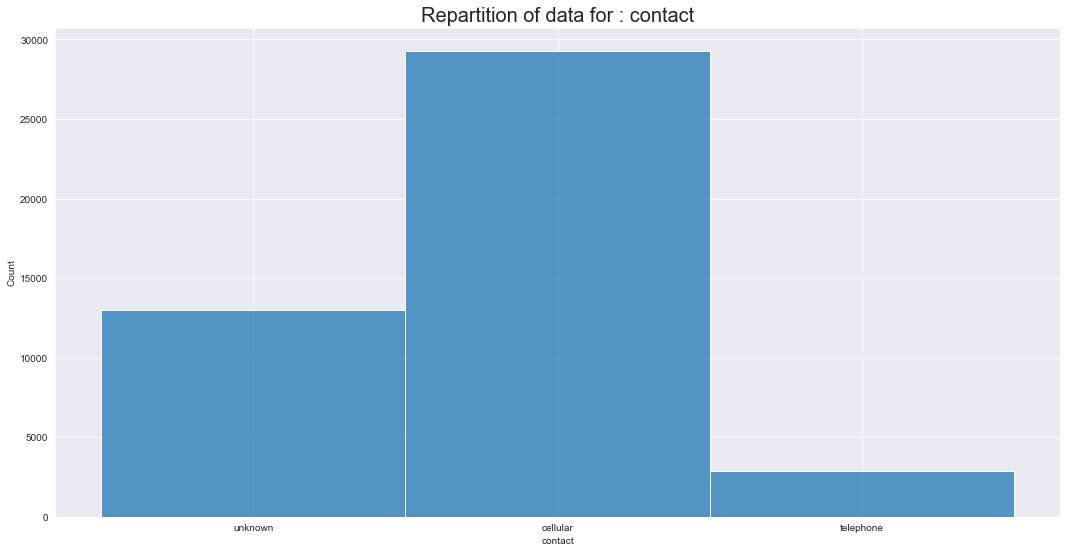

--------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------- study of duration ------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------

124     188
90      184
89      177
104     175
122     175
       ... 
1833      1
1545      1
1352      1
1342      1
1556      1
Name: duration, Length: 1573, dtype: int64



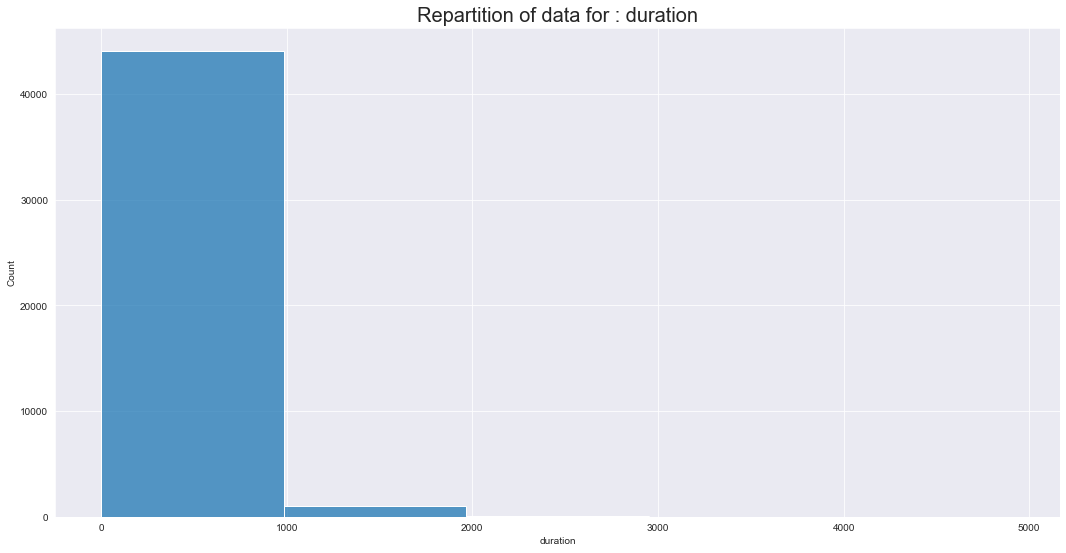

--------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------- study of campaign ------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------

1     17544
2     12505
3      5521
4      3522
5      1764
6      1291
7       735
8       540
9       327
10      266
11      201
12      155
13      133
14       93
15       84
16       79
17       69
18       51
19       44
20       43
21       35
22       23
25       22
23       22
24       20
29       16
28       16
26       13
31       12
27       10
32        9
30        8
33        6
34        5
36        4
35        4
43        3
38        3
37        2
50        2
41        2
46        1
58        1
55        1
63        1
51        1
39        1
44        1
Name: campaign, dtype: int64



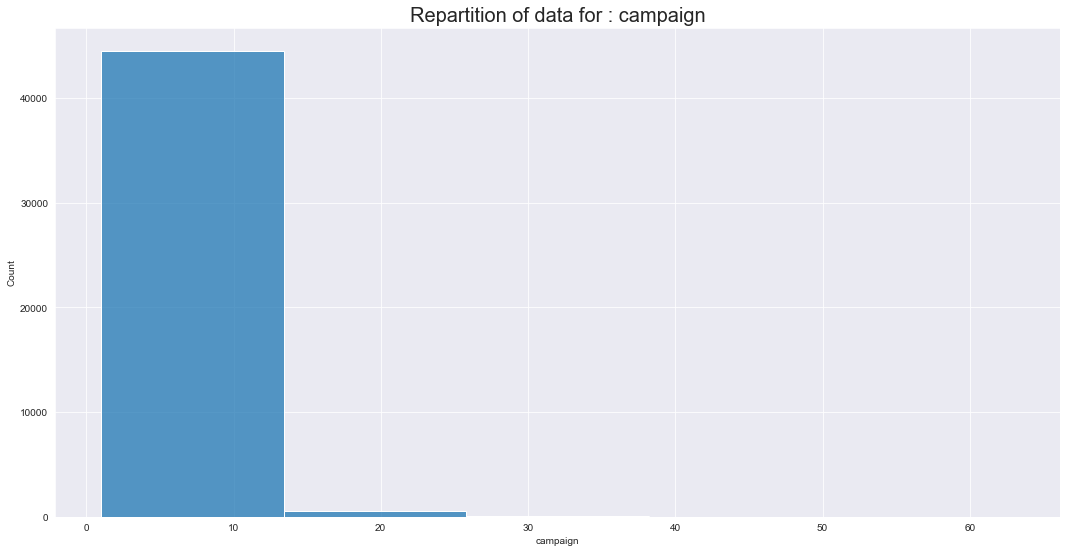

--------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------- study of pdays ------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------

-1      36954
 182      167
 92       147
 91       126
 183      126
        ...  
 449        1
 452        1
 648        1
 595        1
 530        1
Name: pdays, Length: 559, dtype: int64



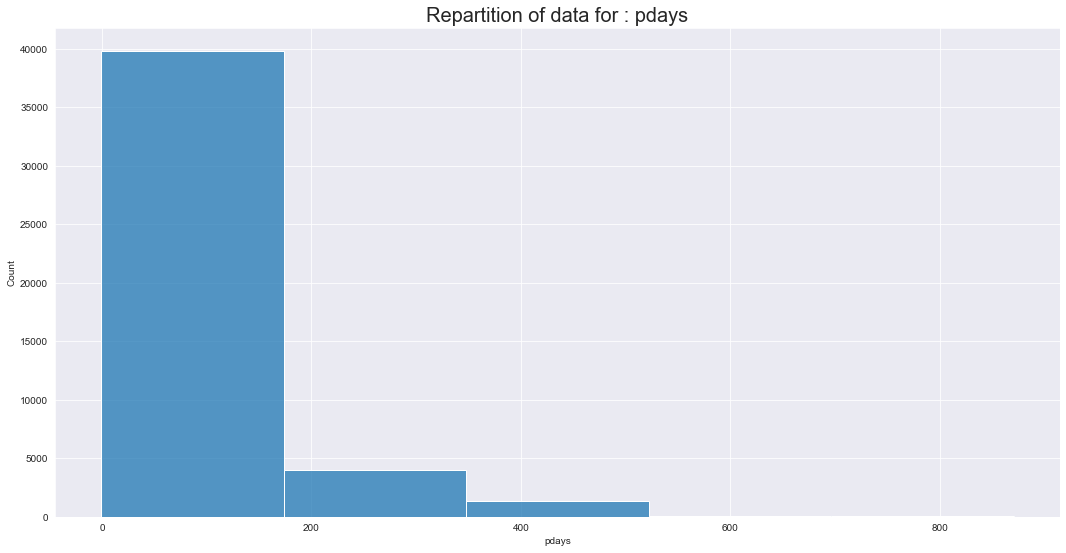

--------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------- study of previous ------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------

0      36954
1       2772
2       2106
3       1142
4        714
5        459
6        277
7        205
8        129
9         92
10        67
11        65
12        44
13        38
15        20
14        19
17        15
16        13
19        11
20         8
23         8
18         6
22         6
24         5
27         5
21         4
29         4
25         4
30         3
38         2
37         2
26         2
28         2
51         1
275        1
58         1
32         1
40         1
55         1
35         1
41         1
Name: previous, dtype: int64



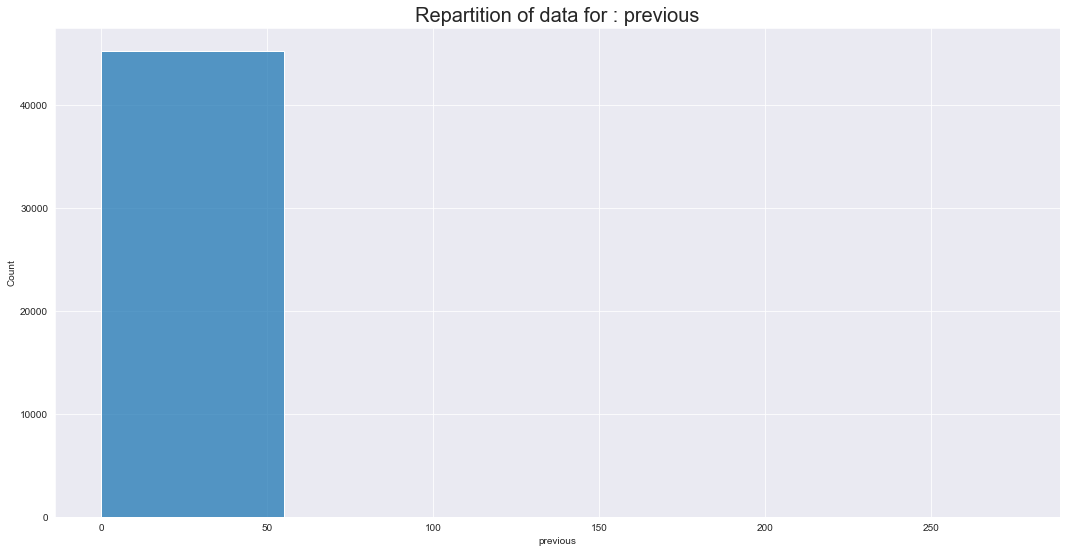

--------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------- study of poutcome ------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------

unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64



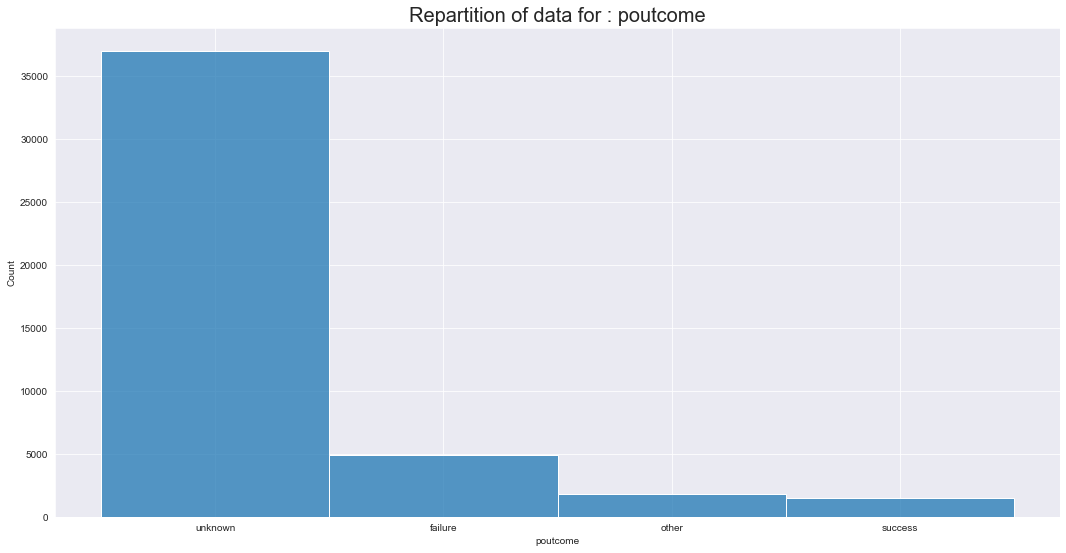

--------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------- study of y ------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------

no     39922
yes     5289
Name: y, dtype: int64



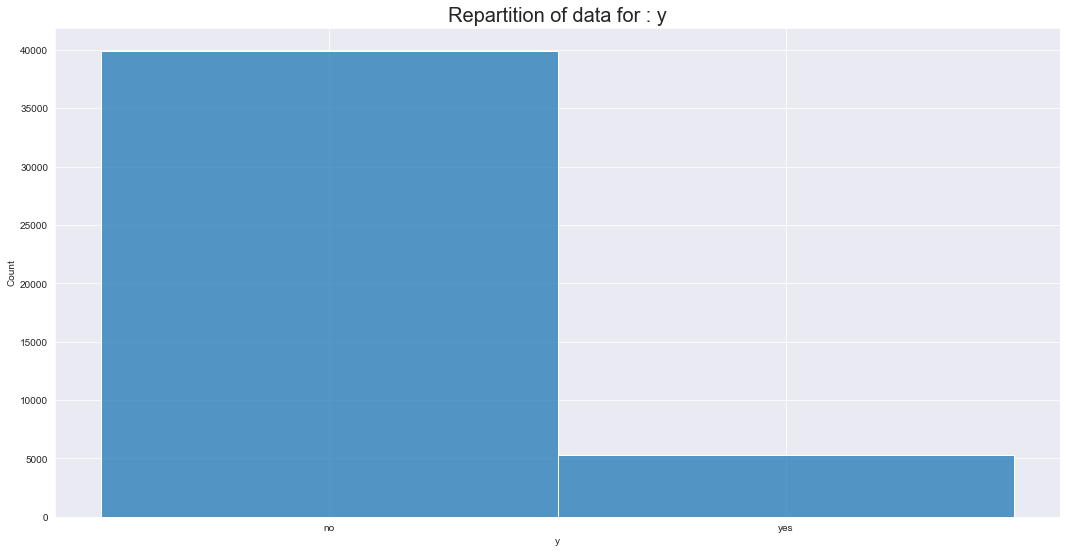

--------------------------------------------------------------------------------------------------------------------------------
--------------------------------------------- study of dayoftheyear ------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------

136    1126
135    1011
134    1002
128     891
129     841
       ... 
162       1
343       1
52        1
348       1
214       1
Name: dayoftheyear, Length: 318, dtype: int64



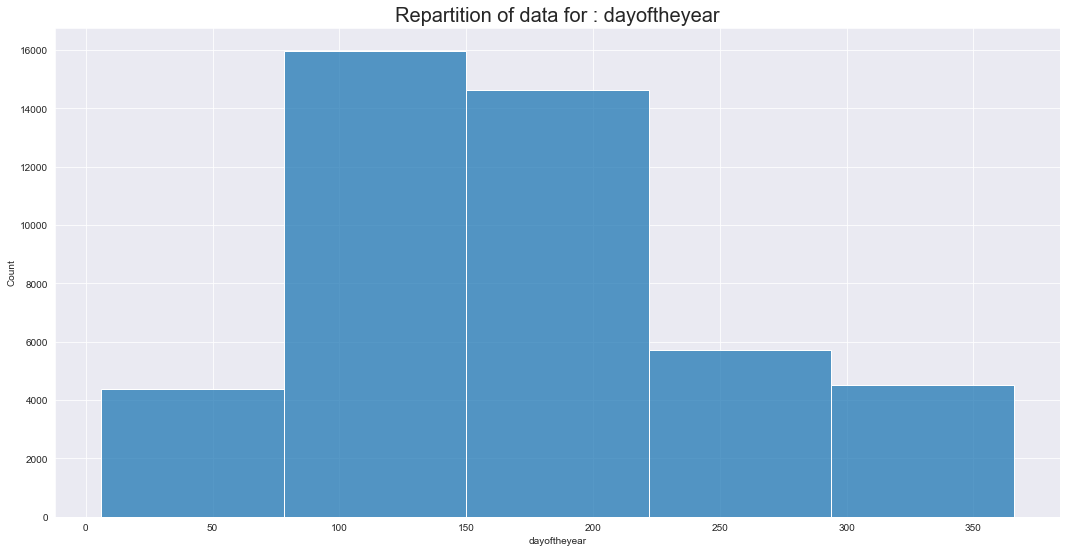

In [88]:
for col in df.columns:
    print("--------------------------------------------------------------------------------------------------------------------------------")
    print(f"--------------------------------------------- study of {col} ------------------------------------------------------------------")
    print("--------------------------------------------------------------------------------------------------------------------------------")
    
    print("")
    print(df[col].value_counts())
    print("")
    
    fig, ax = plt.subplots(figsize=(18,9))
    sns.histplot(df[col], kde=False, bins=5)
    ax.set_title(f"Repartition of data for : {col}", fontsize=20)
    plt.show()

### Heatmap

Use heatmap to display the numerical features' correlation

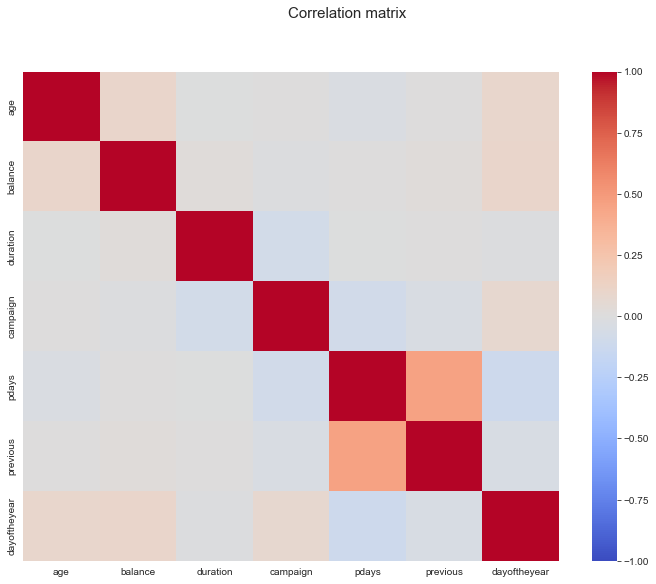

In [89]:
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle("Correlation matrix", fontsize=15)

ax = sns.heatmap(
        df.corr(), 
        cmap="coolwarm", 
        vmin=-1, 
        vmax=1
    )

### Handling date

In order to continue the preprocessing, the features `day` and `month` should be merged into one column named `dayoftheyear`.

You can use pandas datetime tools or python datetime librairies for doing this preprocessing.
(the default year used will be 1984)

In [90]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y,dayoftheyear
0,58,management,married,tertiary,no,2143,yes,no,unknown,261,1,-1,0,unknown,no,126
1,44,technician,single,secondary,no,29,yes,no,unknown,151,1,-1,0,unknown,no,126
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,76,1,-1,0,unknown,no,126
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,92,1,-1,0,unknown,no,126
4,33,unknown,single,unknown,no,1,no,no,unknown,198,1,-1,0,unknown,no,126


In [91]:
df['dayoftheyear'] = pd.to_datetime('1984-' + df['month'].astype(str) + '-' + df['day'].astype(str)).dt.strftime('%j').astype(int)
df["dayoftheyear"]

KeyError: 'month'

Now sort the features into categorical and numerical features

In [ ]:
categorical_features = cat_col
numerical_features = num_col
if "dayoftheyear" not in numerical_features:
    numerical_features.append("dayoftheyear") # to be completed

# Preprocessing 

After a first exploration, categorical/ordinal features (10 columns) need to be encoded in order to become a valid input for the modeling phase.

The different encoders can be found [here](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing).

(You can also use the function `get_dummies` of pandas for categorical features)

### Drop columns

In [92]:
col_to_drop = ["day", "month"]
for col in col_to_drop:
    try:
        df.drop(columns=col, inplace=True)
    except:
        print("Column not in df")
df.head()

Column not in df
Column not in df


,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y,dayoftheyear
0,58,management,married,tertiary,no,2143,yes,no,unknown,261,1,-1,0,unknown,no,126
1,44,technician,single,secondary,no,29,yes,no,unknown,151,1,-1,0,unknown,no,126
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,76,1,-1,0,unknown,no,126
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,92,1,-1,0,unknown,no,126
4,33,unknown,single,unknown,no,1,no,no,unknown,198,1,-1,0,unknown,no,126


## Split the dataframe

In [93]:
from sklearn.model_selection import train_test_split
print(sklearn.__version__)



1.2.2


In [94]:
dff = df.copy()

df.to_pickle('df.pickle')

In [95]:
y = dff["y"]
dff.drop(columns="y", inplace=True)
dff.to_pickle('dff.pickle')
y.to_pickle('y.pickle')

In [96]:
X_train, X_test, y_train, y_test = train_test_split(dff, y, test_size=0.25, random_state=42, stratify=y)

## Pipeline

In [97]:
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

print(sklearn.__version__)

1.2.2


In [98]:
numerical_features = ["age", "balance", "duration", "campaign", "pdays", "previous", "dayoftheyear"]
categorical_features = ["job", "marital", "education", "default", "housing", "loan", "contact", "poutcome"]

num_pipeline = Pipeline([
     ('std_scaler', StandardScaler()), # try commenting in this line and running fit_transform with and without it
 ])

cat_pipeline = Pipeline([
    ('ord_encoder', OneHotEncoder(sparse=False)),
    ('std_scaler', StandardScaler()),
])


transformer = ColumnTransformer(
    transformers = [
        ("num", num_pipeline, numerical_features),
        ("cat", cat_pipeline, categorical_features)
    ],
    remainder='passthrough'
)

In [99]:
X_train_transformed = transformer.fit_transform(X_train)
X_test_transformed = transformer.transform(X_test)

/Users/manulabricole/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [100]:
# Get feature names from the fitted OneHotEncoder and ordencoder
full_names = transformer.get_feature_names_out()
# Convert the transformed NumPy array back to a DataFrame with proper column names
X_train_transformed = pd.DataFrame(X_train_transformed, columns=full_names)
X_train_transformed.head()

,num__age,num__balance,num__duration,num__campaign,num__pdays,num__previous,num__dayoftheyear,cat__job_admin.,cat__job_blue-collar,cat__job_entrepreneur,...,cat__housing_yes,cat__loan_no,cat__loan_yes,cat__contact_cellular,cat__contact_telephone,cat__contact_unknown,cat__poutcome_failure,cat__poutcome_other,cat__poutcome_success,cat__poutcome_unknown
0,1.609393,-0.446395,0.025207,-0.568697,1.479505,0.170642,2.019994,-0.359985,-0.526941,-0.184992,...,0.891588,0.436997,-0.436997,0.735712,-0.262124,-0.634284,2.881424,-0.206362,-0.185077,-2.123866
1,0.573629,-0.352363,-0.754919,-0.568697,-0.410182,-0.238214,-0.000133,-0.359985,-0.526941,-0.184992,...,-1.121595,0.436997,-0.436997,-1.359227,-0.262124,1.576581,-0.347051,-0.206362,-0.185077,0.470839
2,-0.556295,-0.185266,-0.685403,-0.568697,-0.410182,-0.238214,-0.575401,-0.359985,-0.526941,-0.184992,...,0.891588,0.436997,-0.436997,-1.359227,-0.262124,1.576581,-0.347051,-0.206362,-0.185077,0.470839
3,-0.650456,-0.240965,0.094723,-0.245492,-0.410182,-0.238214,-0.588779,2.777897,-0.526941,-0.184992,...,0.891588,0.436997,-0.436997,-1.359227,-0.262124,1.576581,-0.347051,-0.206362,-0.185077,0.470839
4,-0.556295,-0.416580,-0.283754,0.400918,-0.410182,-0.238214,-0.374726,2.777897,-0.526941,-0.184992,...,0.891588,0.436997,-0.436997,-1.359227,-0.262124,1.576581,-0.347051,-0.206362,-0.185077,0.470839


Now, the dataset needs to be split into two sets :
1. one corresponding to $ŷ$ 
2. the other corresponding to the $X$ matrix.

- Prepare the learning dataset

At the end of this part, two dataframes are created :

- `X` containing the features (or the matrix $X$)
- `y` containing the label (or $ŷ$)

Display the shape of X and y

In [101]:
df.shape

(45211, 16)

In [103]:
yy = y.map({'yes': 1, 'no': 0})
yy.value_counts()

0    39922
1     5289
Name: y, dtype: int64

In [104]:
y.value_counts()

no     39922
yes     5289
Name: y, dtype: int64

Well done! The data is now ready to be splitted into sets and used to train models!

# Modelling phase

The client needs two features :

1. A model, which can be updated without performance loss.
2. A model, that performs well.

## Import & Preprocess data

In [153]:
def import_preprocess(seed):
    dff = pd.read_pickle("dff.pickle")
    y = pd.read_pickle("y.pickle")
    X_train, X_test, y_train, y_test = train_test_split(dff, yy, test_size=0.25, random_state=seed, stratify=yy)
    
    X_train_transformed = transformer.fit_transform(X_train)
    X_test_transformed = transformer.transform(X_test)
    
    # Get feature names from the fitted OneHotEncoder and ordencoder
    full_names = transformer.get_feature_names_out()
    # Convert the transformed NumPy array back to a DataFrame with proper column names
    X_train_transformed = pd.DataFrame(X_train_transformed, columns=full_names)
    X_test_transformed = pd.DataFrame(X_test_transformed, columns=full_names)
    
    return X_train_transformed, X_test_transformed, y_train, y_test

In order to highlight decision trees advantages and drawbacks, remove the `duration` column from the `X` dataset.

In [154]:
X_train, X_test, y_train, y_test = import_preprocess(42)
try:
    X_train.pop("num__duration")
    X_test.pop("num__duration")
    print("Column Removed")
except:
    print("Already Done")

Column Removed


/Users/manulabricole/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [155]:
try:
    X_train.pop("num__duration")
    X_test.pop("num__duration")
    print("Column Removed")
except:
    print("Already Done")

Already Done


Before beginning the modelling phase let's split the dataset into one training set and one testing set.

In [156]:
X_train

,num__age,num__balance,num__campaign,num__pdays,num__previous,num__dayoftheyear,cat__job_admin.,cat__job_blue-collar,cat__job_entrepreneur,cat__job_housemaid,...,cat__housing_yes,cat__loan_no,cat__loan_yes,cat__contact_cellular,cat__contact_telephone,cat__contact_unknown,cat__poutcome_failure,cat__poutcome_other,cat__poutcome_success,cat__poutcome_unknown
0,1.609393,-0.446395,-0.568697,1.479505,0.170642,2.019994,-0.359985,-0.526941,-0.184992,-0.170145,...,0.891588,0.436997,-0.436997,0.735712,-0.262124,-0.634284,2.881424,-0.206362,-0.185077,-2.123866
1,0.573629,-0.352363,-0.568697,-0.410182,-0.238214,-0.000133,-0.359985,-0.526941,-0.184992,-0.170145,...,-1.121595,0.436997,-0.436997,-1.359227,-0.262124,1.576581,-0.347051,-0.206362,-0.185077,0.470839
2,-0.556295,-0.185266,-0.568697,-0.410182,-0.238214,-0.575401,-0.359985,-0.526941,-0.184992,-0.170145,...,0.891588,0.436997,-0.436997,-1.359227,-0.262124,1.576581,-0.347051,-0.206362,-0.185077,0.470839
3,-0.650456,-0.240965,-0.245492,-0.410182,-0.238214,-0.588779,2.777897,-0.526941,-0.184992,-0.170145,...,0.891588,0.436997,-0.436997,-1.359227,-0.262124,1.576581,-0.347051,-0.206362,-0.185077,0.470839
4,-0.556295,-0.416580,0.400918,-0.410182,-0.238214,-0.374726,2.777897,-0.526941,-0.184992,-0.170145,...,0.891588,0.436997,-0.436997,-1.359227,-0.262124,1.576581,-0.347051,-0.206362,-0.185077,0.470839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33903,0.008667,-0.081732,2.986556,-0.410182,-0.238214,-0.147295,-0.359985,-0.526941,-0.184992,-0.170145,...,0.891588,-2.288346,2.288346,-1.359227,-0.262124,1.576581,-0.347051,-0.206362,-0.185077,0.470839
33904,-0.085494,0.060463,-0.568697,-0.410182,-0.238214,2.046751,-0.359985,-0.526941,-0.184992,-0.170145,...,0.891588,0.436997,-0.436997,0.735712,-0.262124,-0.634284,-0.347051,-0.206362,-0.185077,0.470839
33905,-0.462135,-0.439187,0.724122,-0.410182,-0.238214,0.427974,2.777897,-0.526941,-0.184992,-0.170145,...,0.891588,0.436997,-0.436997,0.735712,-0.262124,-0.634284,-0.347051,-0.206362,-0.185077,0.470839
33906,0.385308,-0.420512,-0.568697,-0.410182,-0.238214,0.468108,-0.359985,1.897746,-0.184992,-0.170145,...,0.891588,0.436997,-0.436997,0.735712,-0.262124,-0.634284,-0.347051,-0.206362,-0.185077,0.470839


## Models

We will experiment both feature by doing the two following steps.

* Training the Decision Tree model with various splits of the dataset (change the `seed` parameter of the `train_test_split` function for obtaining the second dataset)
* The decision tree `max_depth` will be fixed at 3 first

if you need more info you can take a look at the [sklearn decision tree doc](https://scikit-learn.org/stable/modules/tree.html).

In [181]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, make_scorer, roc_auc_score, log_loss


### Dummy model

In [158]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_validate

In [159]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
y_dummy_predicted = dummy_clf.predict(X_test)
y_dummy_predicted = pd.DataFrame(y_dummy_predicted)

### Decision Tree - 42

In [160]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [161]:
dtc_42 = DecisionTreeClassifier(max_depth=3)

dtc_42 = dtc_42.fit(X_train, y_train)
y_pred_train = cross_val_predict(dtc_42,X_train, y_train, cv=10)
y_pred_train = pd.DataFrame(y_pred_train)

In [162]:
y_pred_train.value_counts()

0    32905
1     1003
dtype: int64

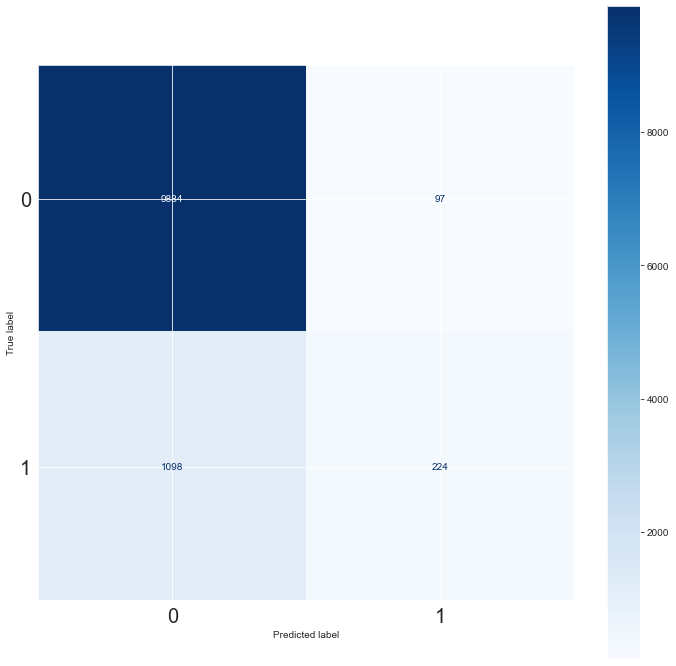

In [163]:
y_test_pred = dtc_42.predict(X_test)
cm = confusion_matrix(y_test, y_test_pred)
cm_display = ConfusionMatrixDisplay(cm)

fig, ax = plt.subplots(figsize=(12, 12))
cm_display.plot(cmap='Blues', ax=ax)
plt.xticks(rotation=0, fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [164]:
accuracy = accuracy_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
print("Accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1_score:", f1)

Accuracy: 0.8942758559674423
recall: 0.16944024205748864
precision: 0.6978193146417445
f1_score: 0.2726719415702982


Now, a first model has been created, change the random seed for the train/test split, and create another tree.

This tree should be created with the same hyperparameters than above. 

In [165]:
X_train, X_test, y_train, y_test = import_preprocess(20)
try:
    X_train.pop("num__duration")
    X_test.pop("num__duration")
    print("Column Removed")
except:
    print("Already Done")

Column Removed


/Users/manulabricole/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [166]:
dtc_20 = DecisionTreeClassifier(max_depth=3)

dtc_20 = dtc_20.fit(X_train, y_train)
y_pred_train = cross_val_predict(dtc_20,X_train, y_train, cv=10)
y_pred_train = pd.DataFrame(y_pred_train)

In [167]:
y_pred_train.value_counts()

0    32894
1     1014
dtype: int64

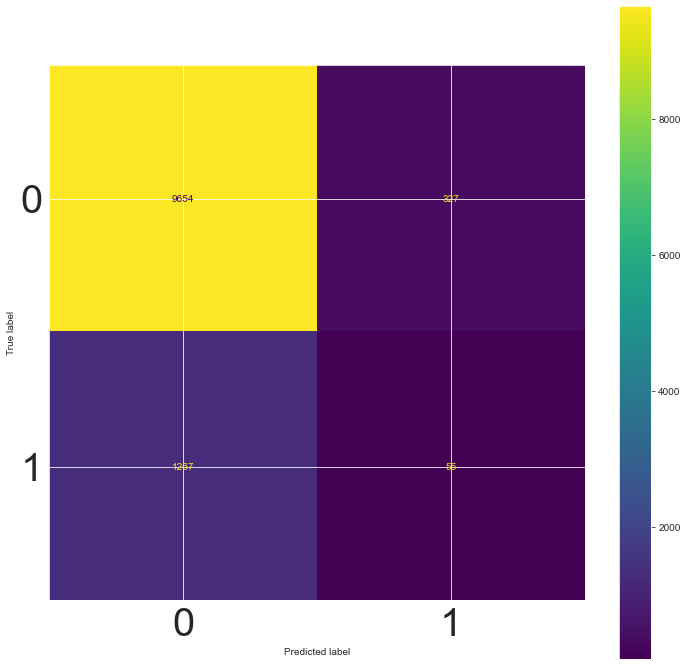

In [343]:
y_test_pred = dtc_20.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(cm)

fig, ax = plt.subplots(figsize=(12, 12))
cm_display.plot(ax=ax)
plt.xticks(rotation=0, fontsize=40)
plt.yticks(fontsize=40)
plt.show()

In [169]:
accuracy = accuracy_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
print("Accuracy:", accuracy)
print("recall:", recall)
print("precision:", precision)
print("f1_score:", f1)

Accuracy: 0.8936565513580466
recall: 0.18986384266263237
precision: 0.6570680628272252
f1_score: 0.29460093896713613


What can you tell about the two trees?

Selon

Normally, before creating a model, one or more evaluation metrics should be chosen depending of the client problem.

* Choose different metrics that seem relevant to this problem (see previous lesson on Classification)

* Prepare a scoring list for these metrics.

* Use the cross-validation method to measure these metrics (if you need see : [cross validation sklearn](https://scikit-learn.org/stable/modules/cross_validation.html)). 

*Hint:*  the `cross_validate` method allows you to pass a metric list as parameter (see [doc here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) ).

In [183]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, make_scorer, roc_auc_score, log_loss, balanced_accuracy_score, average_precision_score


In [184]:
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'balanced_accuracy', 'average_precision']

Now process the output of your cross-validation in order to know the diversity in performances and the average performance

Plot your metrics performance

In [259]:
clf = DecisionTreeClassifier()
cv_results = cross_validate(clf, X_train, y_train, cv=5, scoring=scoring)

/var/folders/vs/63szyqqn4dq91nzk275599p40000gn/T/ipykernel_7188/2383611345.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(scoring, rotation=45)


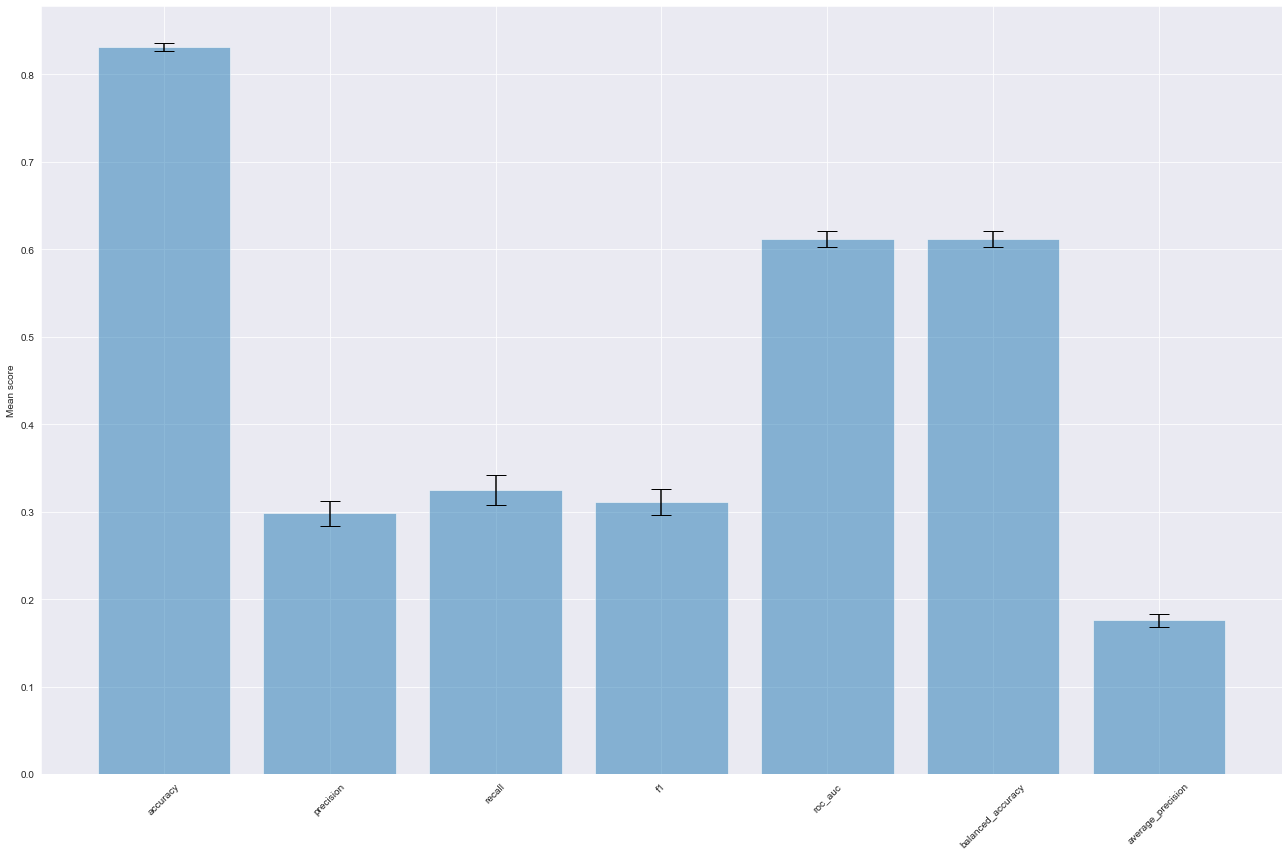

In [260]:
mean_scores = []
std_scores = []
for metric in scoring:
    mean_score = np.mean(cv_results[f'test_{metric}'])
    std_score = np.std(cv_results[f'test_{metric}'])
    mean_scores.append(mean_score)
    std_scores.append(std_score)
# Create bar plot
fig, ax = plt.subplots(figsize=(18,12))
ax.bar(scoring, mean_scores, yerr=std_scores, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Mean score')
ax.set_xticklabels(scoring, rotation=45)
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

<AxesSubplot:>

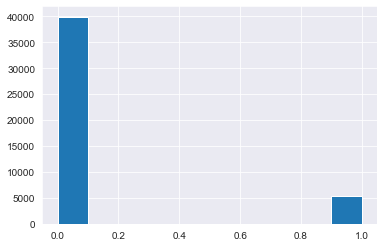

In [187]:
yy.hist()

Now choose a single metric to perform a grid search on the `max_depth` of the tree.

In [261]:
sklearn.metrics.get_scorer_names();

In [196]:
dtc = DecisionTreeClassifier()

param_grid = [{'max_depth': range(1,50,2)}]

grid_search_dtc = GridSearchCV(dtc, param_grid, cv=5, scoring='f1', verbose=2)
grid_search_dtc.fit(X_train, y_train)
grid_results_dtc = pd.DataFrame(grid_search_dtc.cv_results_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=1; total time=   0.0s
[CV] END ........................................max_depth=3; total time=   0.0s
[CV] END ........................................max_depth=3; total time=   0.0s
[CV] END ........................................max_depth=3; total time=   0.0s
[CV] END ........................................max_depth=3; total time=   0.0s
[CV] END ........................................max_depth=3; total time=   0.0s
[CV] END ........................................max_depth=5; total time=   0.0s
[CV] END ......................................

[CV] END .......................................max_depth=41; total time=   0.1s
[CV] END .......................................max_depth=41; total time=   0.1s
[CV] END .......................................max_depth=41; total time=   0.1s
[CV] END .......................................max_depth=43; total time=   0.1s
[CV] END .......................................max_depth=43; total time=   0.2s
[CV] END .......................................max_depth=43; total time=   0.1s
[CV] END .......................................max_depth=43; total time=   0.1s
[CV] END .......................................max_depth=43; total time=   0.1s
[CV] END .......................................max_depth=45; total time=   0.1s
[CV] END .......................................max_depth=45; total time=   0.2s
[CV] END .......................................max_depth=45; total time=   0.2s
[CV] END .......................................max_depth=45; total time=   0.1s
[CV] END ...................

Now retrain the model with the selected hyperparameters on your whole train set and evaluate the selected model on the test set :

In [280]:
grid_results_dtc;

In [210]:
balanced_accuracy_score(y_test, y_test_predict)

0.6116684105246262

In [278]:
f1_train_list = []
f1_test_list = []
k_list = []

for k in range(1,25,1):
    dtc = DecisionTreeClassifier(max_depth=k, class_weight="balanced")
    dtc = dtc.fit(X_train, y_train)
    
    y_train_predict = dtc.predict(X_train)
    y_test_predict = dtc.predict(X_test)
    f1_train = f1_score(y_train, y_train_predict)
    f1_test = f1_score(y_test, y_test_predict)
    
    f1_train_list.append(f1_train)
    f1_test_list.append(f1_test)
    k_list.append(k)
    

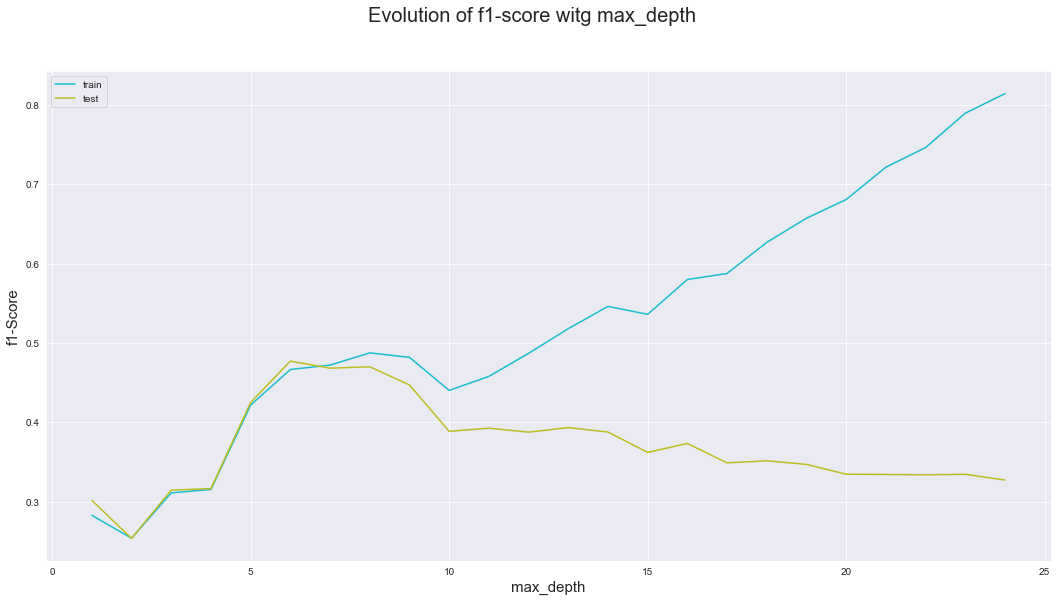

In [279]:

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(18,9))
fig.suptitle("Evolution of f1-score witg max_depth", fontsize=20)

sns.lineplot(
    ax=ax,
    x=k_list, 
    y=f1_train_list, 
    color=colors[0],
    label="train"
)

sns.lineplot(
    ax=ax,
    x=k_list, 
    y=f1_test_list, 
    color=colors[2],
    label="test"
)


ax.set_ylabel("f1-Score", fontsize=15)
ax.set_xlabel("max_depth", fontsize=15)

plt.show()

### Introducing Ensemble Learning with Bagging models.

Let's train multiple classifiers in parallel in a bootstraping approach! 

Bagging stands for ***Boostrap AGGregatING***.

The following [post](https://blog.octo.com/les-methodes-ensemblistes-pour-algorithmes-de-machine-learning/) will give you an overview of these methods and their advantages and drawbacks

**The train test split using a seed equals to 42 will be used in the following part**

In [232]:
X_train, X_test, y_train, y_test = import_preprocess(42)
try:
    X_train.pop("num__duration")
    X_test.pop("num__duration")
    print("Column Removed")
except:
    print("Already Done")

Column Removed


/Users/manulabricole/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#### Using Random Forest

The concept of random forest is explained in this [post](https://medium.com/analytics-vidhya/understanding-the-random-forest-algorithm-79b87bdde79a).

Now the best parameters of the previous classifier will be used in a using a bagging classifier
[sklearn : Random Forest Doc](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random%20forest#sklearn.ensemble.RandomForestClassifier)

We will use grid search on the `n_estimators` and `max_depth` parameters. 

In [250]:
from sklearn.ensemble import RandomForestClassifier

In [291]:
rfc = RandomForestClassifier(class_weight="balanced_subsample")
param_grid = [{'max_depth': range(1,15,2), 'n_estimators':range(1,50,5)}]

In [292]:
grid_search_dtc = GridSearchCV(rfc, param_grid, cv=5, scoring='f1', verbose=2)
grid_search_dtc.fit(X_train, y_train)
grid_results_dtc = pd.DataFrame(grid_search_dtc.cv_results_)

Fitting 5 folds for each of 70 candidates, totalling 350 fits
[CV] END ........................max_depth=1, n_estimators=1; total time=   0.0s
[CV] END ........................max_depth=1, n_estimators=1; total time=   0.0s
[CV] END ........................max_depth=1, n_estimators=1; total time=   0.0s
[CV] END ........................max_depth=1, n_estimators=1; total time=   0.0s
[CV] END ........................max_depth=1, n_estimators=1; total time=   0.0s
[CV] END ........................max_depth=1, n_estimators=6; total time=   0.1s
[CV] END ........................max_depth=1, n_estimators=6; total time=   0.1s
[CV] END ........................max_depth=1, n_estimators=6; total time=   0.1s
[CV] END ........................max_depth=1, n_estimators=6; total time=   0.1s
[CV] END ........................max_depth=1, n_estimators=6; total time=   0.1s
[CV] END .......................max_depth=1, n_estimators=11; total time=   0.1s
[CV] END .......................max_depth=1, n_

[CV] END ........................max_depth=5, n_estimators=6; total time=   0.1s
[CV] END ........................max_depth=5, n_estimators=6; total time=   0.1s
[CV] END ........................max_depth=5, n_estimators=6; total time=   0.1s
[CV] END ........................max_depth=5, n_estimators=6; total time=   0.1s
[CV] END .......................max_depth=5, n_estimators=11; total time=   0.2s
[CV] END .......................max_depth=5, n_estimators=11; total time=   0.2s
[CV] END .......................max_depth=5, n_estimators=11; total time=   0.2s
[CV] END .......................max_depth=5, n_estimators=11; total time=   0.2s
[CV] END .......................max_depth=5, n_estimators=11; total time=   0.2s
[CV] END .......................max_depth=5, n_estimators=16; total time=   0.2s
[CV] END .......................max_depth=5, n_estimators=16; total time=   0.2s
[CV] END .......................max_depth=5, n_estimators=16; total time=   0.2s
[CV] END ...................

[CV] END ........................max_depth=9, n_estimators=6; total time=   0.1s
[CV] END .......................max_depth=9, n_estimators=11; total time=   0.2s
[CV] END .......................max_depth=9, n_estimators=11; total time=   0.2s
[CV] END .......................max_depth=9, n_estimators=11; total time=   0.2s
[CV] END .......................max_depth=9, n_estimators=11; total time=   0.2s
[CV] END .......................max_depth=9, n_estimators=11; total time=   0.2s
[CV] END .......................max_depth=9, n_estimators=16; total time=   0.3s
[CV] END .......................max_depth=9, n_estimators=16; total time=   0.3s
[CV] END .......................max_depth=9, n_estimators=16; total time=   0.3s
[CV] END .......................max_depth=9, n_estimators=16; total time=   0.3s
[CV] END .......................max_depth=9, n_estimators=16; total time=   0.3s
[CV] END .......................max_depth=9, n_estimators=21; total time=   0.4s
[CV] END ...................

[CV] END ......................max_depth=13, n_estimators=11; total time=   0.2s
[CV] END ......................max_depth=13, n_estimators=11; total time=   0.2s
[CV] END ......................max_depth=13, n_estimators=11; total time=   0.2s
[CV] END ......................max_depth=13, n_estimators=11; total time=   0.3s
[CV] END ......................max_depth=13, n_estimators=16; total time=   0.4s
[CV] END ......................max_depth=13, n_estimators=16; total time=   0.4s
[CV] END ......................max_depth=13, n_estimators=16; total time=   0.4s
[CV] END ......................max_depth=13, n_estimators=16; total time=   0.4s
[CV] END ......................max_depth=13, n_estimators=16; total time=   0.3s
[CV] END ......................max_depth=13, n_estimators=21; total time=   0.5s
[CV] END ......................max_depth=13, n_estimators=21; total time=   0.5s
[CV] END ......................max_depth=13, n_estimators=21; total time=   0.5s
[CV] END ...................

How much estimators should we use for obtaining an optimal result? (in terms of time and performance)

In [296]:
grid_results_dtc

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.014329,0.001570,0.003523,0.000235,1,1,"{'max_depth': 1, 'n_estimators': 1}",0.285856,0.254288,0.252114,0.270756,0.280561,0.268715,0.013580,70
1,0.055822,0.001880,0.004685,0.000141,1,6,"{'max_depth': 1, 'n_estimators': 6}",0.357323,0.303781,0.277139,0.309356,0.296576,0.308835,0.026578,61
2,0.100363,0.003505,0.005856,0.000131,1,11,"{'max_depth': 1, 'n_estimators': 11}",0.292708,0.265177,0.295558,0.314688,0.304060,0.294438,0.016511,66
3,0.143489,0.001905,0.007063,0.000153,1,16,"{'max_depth': 1, 'n_estimators': 16}",0.256535,0.284659,0.275449,0.311150,0.304430,0.286444,0.019761,69
4,0.190390,0.002522,0.008476,0.000308,1,21,"{'max_depth': 1, 'n_estimators': 21}",0.310173,0.283161,0.276137,0.296394,0.331371,0.299447,0.019759,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,0.556212,0.005845,0.023196,0.000179,13,26,"{'max_depth': 13, 'n_estimators': 26}",0.423567,0.426738,0.411865,0.437817,0.432099,0.426417,0.008743,3
66,0.657401,0.004242,0.026980,0.000233,13,31,"{'max_depth': 13, 'n_estimators': 31}",0.427594,0.436267,0.408004,0.418144,0.437778,0.425557,0.011236,5
67,0.761367,0.010359,0.031016,0.000288,13,36,"{'max_depth': 13, 'n_estimators': 36}",0.418280,0.434549,0.418972,0.427721,0.430653,0.426035,0.006429,4
68,0.868728,0.007735,0.034787,0.000304,13,41,"{'max_depth': 13, 'n_estimators': 41}",0.430769,0.435856,0.412646,0.423919,0.437465,0.428131,0.009070,2


<AxesSubplot:xlabel='param_n_estimators', ylabel='mean_test_score'>

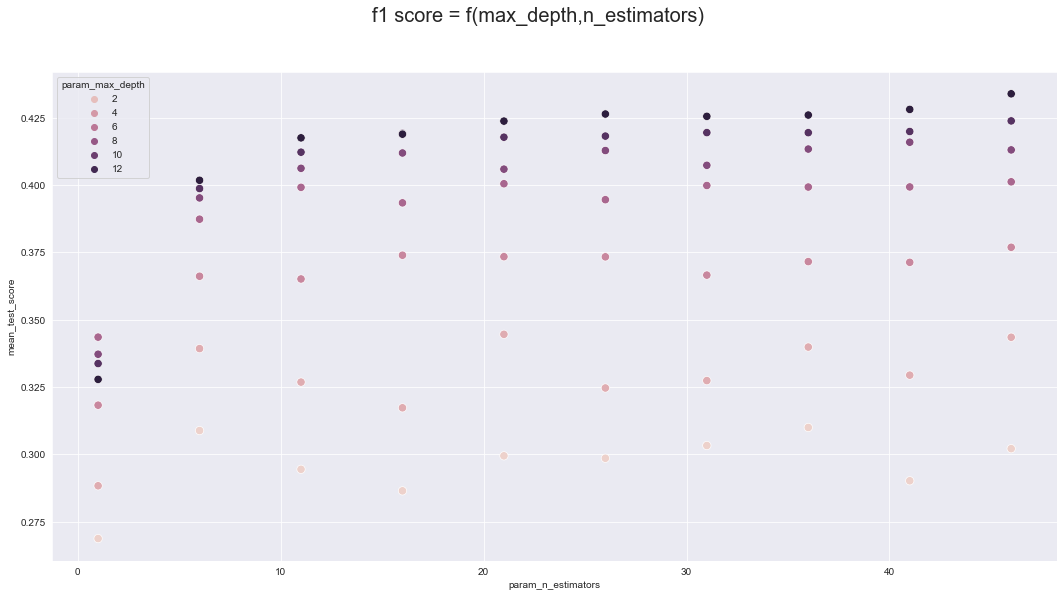

In [297]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(18,9))
fig.suptitle("f1 score = f(max_depth,n_estimators)", fontsize=20)

sns.scatterplot(
    ax=ax,
    data = grid_results_dtc,
    x=grid_results_dtc["param_n_estimators"], 
    y=grid_results_dtc["mean_test_score"],
    hue="param_max_depth",
    s=70,
    color=colors[0],
)

<AxesSubplot:xlabel='param_n_estimators', ylabel='mean_fit_time'>

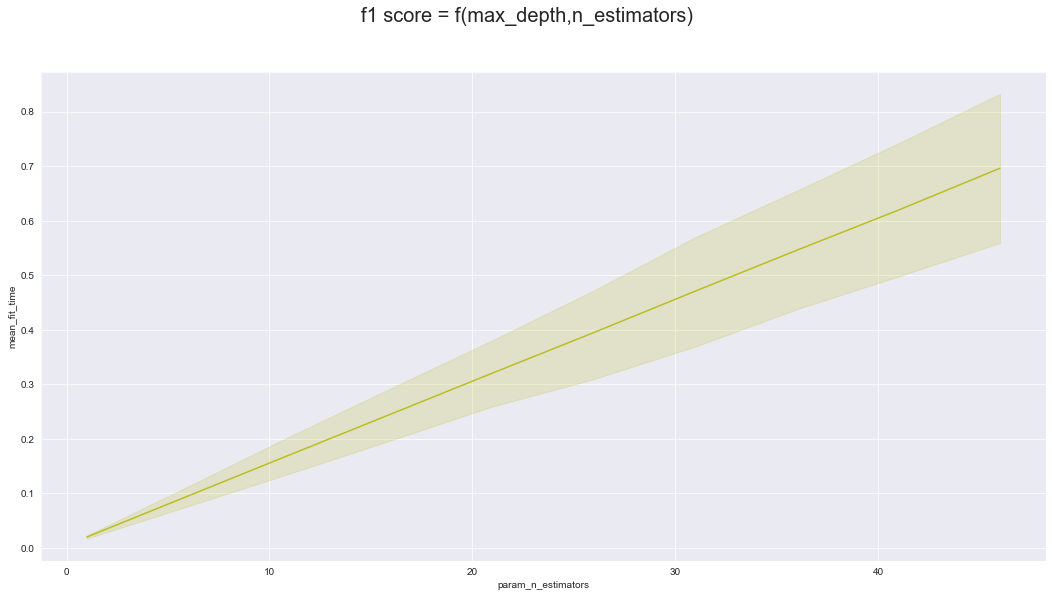

In [298]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(18,9))
fig.suptitle("f1 score = f(max_depth,n_estimators)", fontsize=20)

sns.lineplot(
    ax=ax,
    data = grid_results_dtc,
    x=grid_results_dtc["param_n_estimators"], 
    y=grid_results_dtc["mean_fit_time"],
    color=colors[2],
)

--> f1 score is best at n=20

--> Meme en doublant le nombre d'arbre on n augmente pas le f1-score mais la durée elle double

Now retrain the model with the selected hyperparameters on your whole train set and evaluate the selected model on the test set :

In [322]:
rfc = RandomForestClassifier(max_depth=10, n_estimators=20, class_weight="balanced_subsample", random_state=0)
rfc =rfc.fit(X_train, y_train)

y_train_pred = rfc.predict(X_train)
y_test_pred = rfc.predict(X_test)

print("f1_train", f1_score(y_train, y_train_pred))
print("f1_test", f1_score(y_test, y_test_pred))

f1_train 0.4732810336871251
f1_test 0.42643805309734517


<AxesSubplot:>

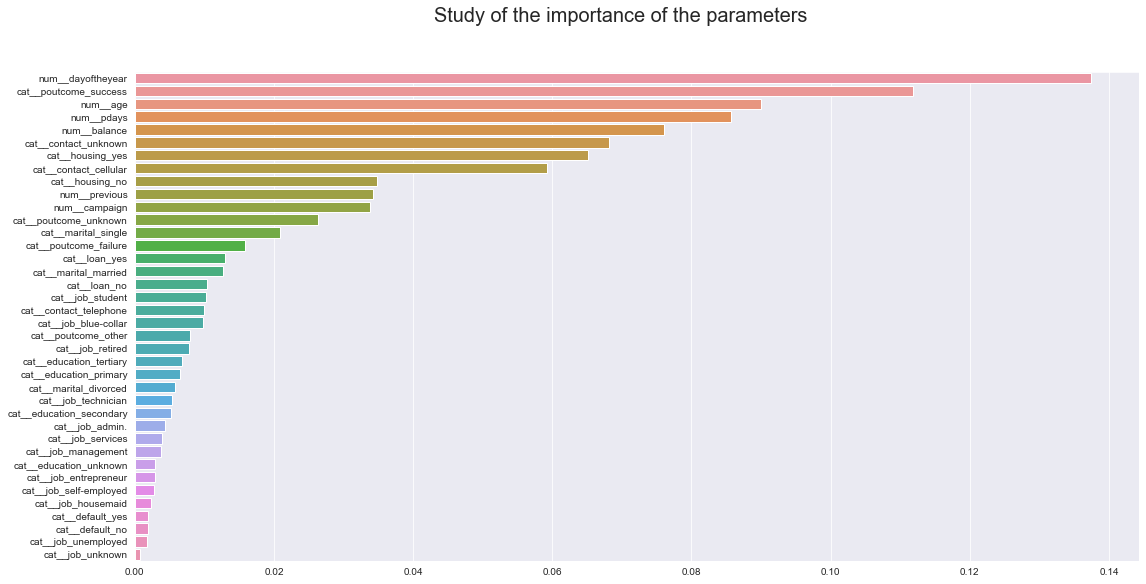

In [323]:
importances = rfc.feature_importances_
sorted_indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(18,9))
fig.suptitle("Study of the importance of the parameters", fontsize=20)

sns.barplot(
    ax=ax,
    x=importances[sorted_indices], 
    y=X_train.columns[sorted_indices],
)

In [335]:
X_train_sorted_col = X_train.columns[sorted_indices]
X_train_sorted_col = X_train_sorted_col[1:8].tolist()
X_train_sorted_col

['cat__poutcome_success',
 'num__age',
 'num__pdays',
 'num__balance',
 'cat__contact_unknown',
 'cat__housing_yes',
 'cat__contact_cellular']

In [345]:
X_train_reducted = X_train[X_train_sorted_col]
X_test_reducted = X_test[X_train_sorted_col]

rfc = RandomForestClassifier(max_depth=10, n_estimators=20, class_weight="balanced_subsample", random_state=0)
rfc =rfc.fit(X_train_reducted, y_train)

y_train_pred = rfc.predict(X_train_reducted)
y_test_pred = rfc.predict(X_test_reducted)

print("f1_train", f1_score(y_train, y_train_pred))
print("f1_test", f1_score(y_test, y_test_pred))

f1_train 0.3965946510320456
f1_test 0.35690396559961773


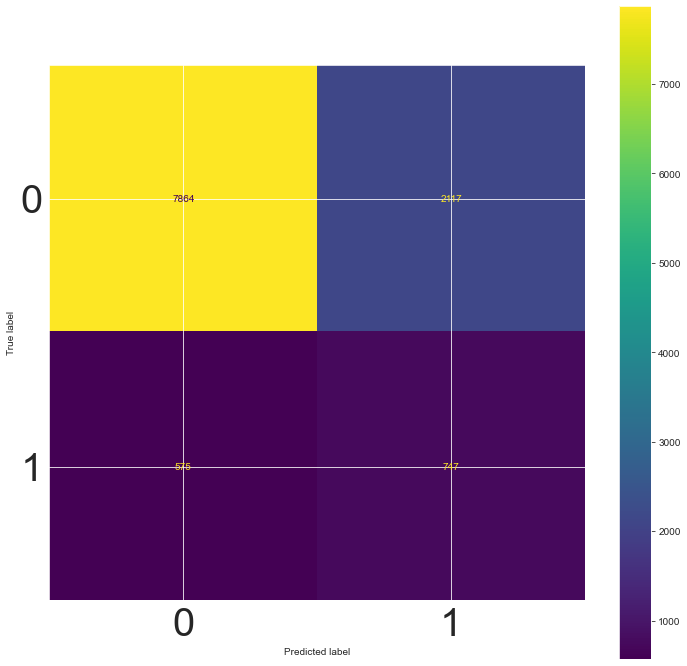

In [346]:
cm = confusion_matrix(y_test, y_test_pred)
cm_display = ConfusionMatrixDisplay(cm)

fig, ax = plt.subplots(figsize=(12, 12))
cm_display.plot(ax=ax)
plt.xticks(rotation=0, fontsize=40)
plt.yticks(fontsize=40)
plt.show()

#### Other Random Forest effect

The random forest model can attribute an importance value to features, [explanations here](https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e)

Let's train another random forest and display an histogramm with it :

In [ ]:
# training and display features' importance.
# tell them to use the RandomForest Object

What is the most important feature?

*Answer here*

### Continue Ensemble Learning with boosting techniques

Bagging permits to average the results of separated models, whereas the boosting technique trains a classifier and optimizes it in function of its error.

Some information about boosting techniques are on the [sklearn documentation](https://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting) but a commonly used library for these techniques is [XGBoost](https://xgboost.readthedocs.io/en/latest/index.html) there are some compatibilities with the sklearn methods (gridsearch, cross validation,...)

- install the `xgboost` package

*Read the articles in resources for a complete explanation.*

In this part a classifier will be trained and evaluated.

In [ ]:
# use the same split and seed than you used before

*Hint:* An example for integrating `XGBoost` with  the `sklearn` tools is available [here](https://medium.com/@juniormiranda_23768/ensemble-methods-tuning-a-xgboost-model-with-scikit-learn-54ff669f988a)

In [ ]:
import xgboost as xgb

Let's build a new model than before with a grid search on the `n_estimators` and `max_depth` parameters.

In [ ]:
# model building and evaluation

Now retrain the model with the selected hyperparameters on your whole train set and evaluate the selected model on the test set :

In [ ]:
# Test metrics

In [ ]:
# performance curves

## Let's Conclude

Report your test set metrics for the three methods here

In [ ]:
# Decision Tree on test set

In [ ]:
# Random forest on test set

In [ ]:
# XGBoost on test set

What do you notice?

*answer here*

- Write your memo about bagging and boosting method in a cell below.
- Which model would you choose for the bank, and why?

you can add your models result visualization in this cell if it helps you explaining your conclusions.

                                 `write memo here`

## To go further

### Build a customized bagging classifier (Optional) 

- Use a different classification model you have seen until now and build a new classifier based on the [BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier) to create and train an new model.
- Use differents classification models and use the [VotingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier) to create and train an new model.

In [ ]:
# Write your code here

## Rebalance the data

Before going through the modelling phase, let's see the label distribution :

Use the `value_counts` function and the appropriate visualization for displaying the label distribution

In [ ]:
# code here

What do you notice?

*answer here*

You can find some techniques for rebalancing the data [here](https://blog.octo.com/donnees-desequilibrees-que-faire/), [here](https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/) and [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html).

Rebalance the data.

In [ ]:
# code here